# CPSC320: Program 5 - Variational Autoencoder (VAE) on Flower Dataset (Run on Google Colab)
In this programming assignment, you will build a VAE for generating flower images.

**Important**: The notebook you will submit must be the one you have RUN all the cells (DO NOT CLEAR OUTPUTS OF ALL CELLS).


**Hints**: You may refere to the scripts of *08_4_VAEs_celeba_colab.ipynb* and get most of he code from there. You need to make some adjustments wherever necessary.

In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, losses
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  0
/bin/bash: line 1: nvidia-smi: command not found


## 1. Dataset Preparation

**Note**:
- The setup for this section should be very similar to the section 1 of the previous program.
- If you have your own machine with gpu installed, you may modify your scripts in Section 1 as you did in program 4.

### 1.1 Upload Dataset to Google Colab

In [3]:
# mount to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

#WARNING: YOU MUST CHANGE THE ZIP PATH SO IT READS THE ZIPPED DATASET FROM YOUR GOOGLE DRIVE#

zip_path = '/content/drive/MyDrive/data/flowers_train_validation.zip'  # Change this to your zip path
extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


### 1.2: Data Preprocessing

#### 1.2.1 Using image_dataset_from_directory for constructing training dataset

**Task 1: Read image_dataset_from_directory**:

Do the followings:
- Provide your train dateset directory unzipped from Section 1.1.
- Set your image_size to be (64, 64).
- Set your batch_size to be 128.
- Modify other arguments if necessary.

In [5]:
# Load the train data
# We only use training dataset to build our VAE model
train_dataset = "./flowers_train_validation/train"
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dataset,  # this is the train dataset folder on your google colab
    color_mode= "rgb",
    image_size= (64, 64),
    batch_size=128,
    labels=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 3456 files.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.2 Preprocessing images

**Task 2: Preprocessing image**

Preprocess the imput image so that it is normalized into the value between (0, 1) *i.e.*, divided by 255.0, and then return the normalized image back.

**Important:**, we not going to return a typical tuple (img, img), (img, label) as used in our autoencoder or classification model.

**Why?** If you adopt the VAE model from *08_4_VAEs_celeba_colab.ipynb*  *train_step* method assumes data only conains imaage, not a tuple of (image,label), or (image,image)

In [6]:
# Preprocess the data
def preprocess(img):
  return img / 255


In [7]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data

**Note**: If all the above steps are set correctly, you should be able  to see the images read frm training data.

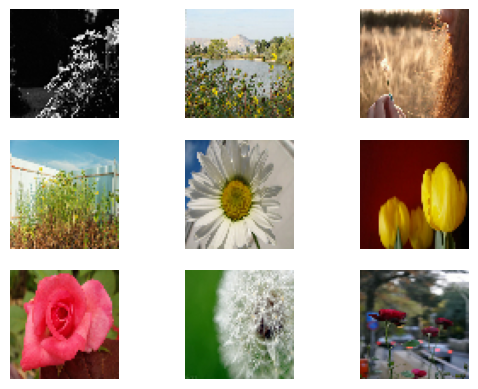

In [8]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the VAE Model

### 2.1 Sampling


**Task 3: Define sampling class**

First, you will build the `Sampling` class. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = logrithm of variance, and $\epsilon$ = random sample

In [9]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      tensor combined with a random sample
    """
    (mu, sigma) = inputs
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
    return mu + tf.exp(0.5 * sigma) * epsilon


### 2.2 The encoder

**Task 4: Encoder**:

Define your encoder (**on your own choices**) that compresses the input image to a lower-dimensional latent representation.
 - It uses Convolutional layers to reduce the spatial dimensions and a Flatten layer to create a latent vector.
 - The outputs are the mean and log variance vectors of the latent space.
 - Suggested Latent Space **dimension = 50** (don't make it too big as our training set size is only about 3000 vs celeb dataset size = 200,000
 - print out encoder model summary

**Note**: You may refer encoder model in *08_4_VAEs_celeba_colab.ipynb*


In [10]:

"""
## Step 4: Define the Encoder
The encoder compresses the input image to a lower-dimensional latent representation.
It uses Convolutional layers to reduce the spatial dimensions and a Flatten layer to create a latent vector.
The outputs are the mean and log variance vectors of the latent space.
"""

# Encoder implementation here....
encoder_input = layers.Input(
    shape=(64, 64, 3), name="encoder_input"
)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(50, name="z_mean")(x)
z_log_var = layers.Dense(50, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# encoder = None











Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 32)       │          9,248 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 32)       │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 8, 8, 32)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 32)       │          9,248 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 4, 4, 32)       │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 4, 4, 32)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 50)             │         25,650 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 50)             │         25,650 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 50)             │              0 │ z_mean[0][0],          │
│                      

 Total params: 80,452 (314.27 KB)

 Trainable params: 80,196 (313.27 KB)

 Non-trainable params: 256 (1.00 KB)

## 2.2 The decoder

**Task 5: Decoder**:

Define your decoder **on your own choices**, but you may follow the common strategies:

- **Mirror the Encoder Architecture**. If the encoder uses convolutional layers, the decoder generally uses transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., Sigmoid for pixel values in the range [0, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, you should have the same number of channels and spatial dimensions as the original input image i.e., **(64, 64 ,3)**. So you need cropping or padding if necessary.

Print out your decoder's model summary.

In [11]:
# Cell 5: Define the Decoder
"""
## Step 5: Define the Decoder
The decoder reconstructs the original image from the latent representation.
It uses Dense and Conv2DTranspose layers to upsample and reshape the latent vector back to the original image shape.
"""

# Decoder
decoder_input = layers.Input(shape=(50,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    3, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          26,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,411 (1.96 MB)

 Trainable params: 511,363 (1.95 MB)

 Non-trainable params: 2,048 (8.00 KB)

## 2.3 Autoencoder

**Task 6: VAE**:

You will define VAE model class  inherits model.Model. You may copy most of VAE model implemenation from *08_4_VAEs_celeba_colab.ipynb*, but you pay particular attention to the followings:
- *train_step*:
  - For the reconstruction_loss: you may try multiply **10,000 or 15,000** by losses.MeanSquaredError()(data, reconstruction), because we calculate mean square error for 64X64X3=12288 pixels, so the total error is rougly 10,000 or 15,000.
- *test_step*: you don't need it, so just remove it from the VAE class


In [12]:
"""
## Step 6: Define the VAE Class
The VAE class integrates the encoder, decoder, and sampling function.
The custom `train_step()` method handles forward pass and loss calculation.
"""
class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def call(self, inputs):
      """Call the model on a particular input."""
      z_mean, z_log_var, z = encoder(inputs)
      reconstruction = decoder(z)
      return z_mean, z_log_var, reconstruction

  def train_step(self, data):
      """Step run during training."""
      with tf.GradientTape() as tape:
          z_mean, z_log_var, reconstruction = self(data, training=True)
          reconstruction_loss = tf.reduce_mean(
              15000 * tf.keras.losses.MeanSquaredError()(data, reconstruction)
          )
          kl_loss = tf.reduce_mean(
              tf.reduce_sum(
                  -0.5
                  * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                  axis=1,
              )
          )
          total_loss = reconstruction_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }

## 3. Compile and Train the model

**Task 7: Create a VAE model instance and Compile**:

-  Create an instance of the VAE class using the encoder and decoder models defined earlier.
- Compile it using the Adam optimizer.

In [13]:
# Create a VAE model instance and Compile
model = VAE(encoder, decoder)
model.compile(optimizer="adam")


**Task 8: Model fit**:

Do model fitting on your **train_data** from Section 1.2.3, set epochs to **500**.

In [14]:

"""
## Step 8: Train the VAE
We'll train the VAE using the dataset defined earlier.
"""

model.fit(train_data, epochs=50)



Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - kl_loss: 0.2595 - loss: 1317.2627 - reconstruction_loss: 1317.0033
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - kl_loss: 10.6465 - loss: 1142.3677 - reconstruction_loss: 1131.7211
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - kl_loss: 24.7875 - loss: 848.8480 - reconstruction_loss: 824.0605
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - kl_loss: 36.2320 - loss: 745.1025 - reconstruction_loss: 708.8705
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - kl_loss: 42.3158 - loss: 704.8633 - reconstruction_loss: 662.5475
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - kl_loss: 45.9295 - loss: 688.3347 - reconstruction_loss: 642.4052
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - kl_loss: 48.2252 - loss: 651.1110 - reconstruction_loss: 602.8858
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - kl_loss: 52.7771 - loss: 608.1131 - reconstruction_loss: 555.3360
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 213s 7s

## 4. Reconstruct using the variational autoencoder

In [15]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

**Task 9: Reconstruct images:**
- Select the first subset of the training set (done for you)
- Create autoencoder predictions and display

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step
Example real faces


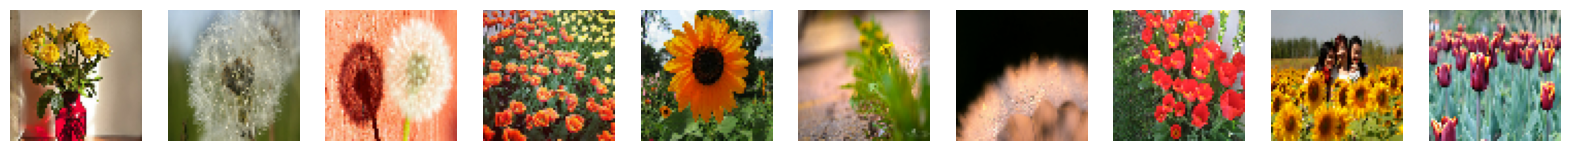

Reconstructions


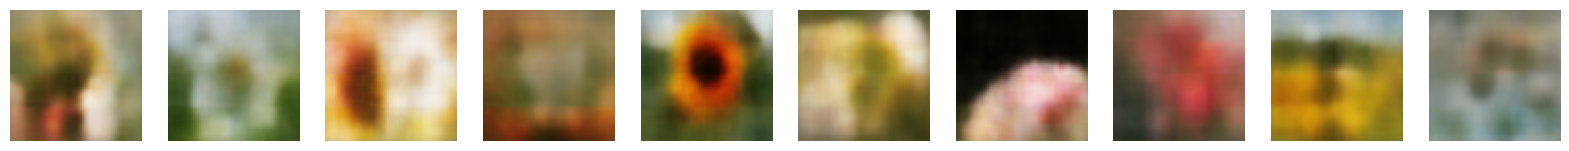

In [20]:
# Select a subset of the training set
batches_to_predict = 1
example_images = np.array(
    list(train_data.take(batches_to_predict).get_single_element())
)

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = model.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Generating New Images

**Task 10: Generating new images**
- Generate z_samples using *np.random.normal*, with sample size of grid_width * grid_height and **latent_dim = 50** (if defined 50 in your encoder model)
- Decoder the sampled points and save them in reconstructions for image display.

In [22]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 50))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


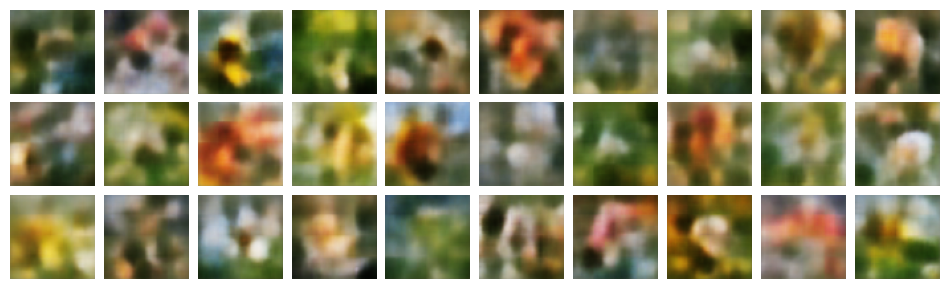

In [23]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(12, 3.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])